Simulation plot saved to: led_simulation_result.png


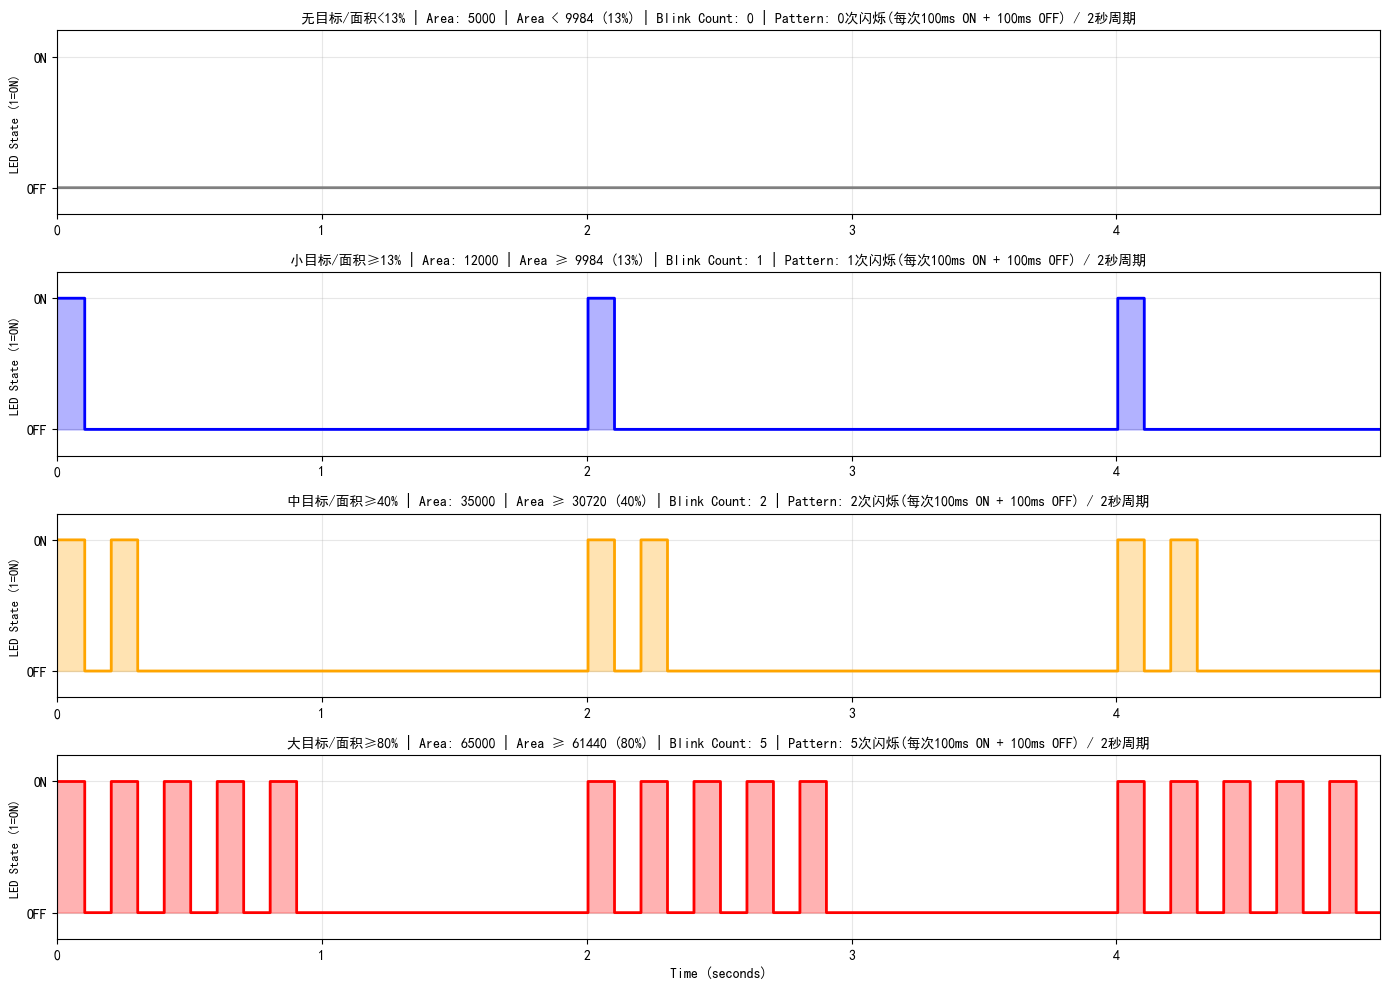

In [5]:
import math
import matplotlib.pyplot as plt
import numpy as np

# --- 1. 定义常量 (与 simple_detect.py 保持一致) ---
GLOBAL_PERIOD_MS = 2000    # 大周期 2秒
SUB_PERIOD_MS = 200        # 小周期 200ms (100亮+100灭)
SUB_ON_MS = 100            # 小周期中亮的时长

# 面积阈值 (基于 QVGA 320x240 = 76800 像素)
TOTAL_PIXELS = 320 * 240
AREA_THRESH_80 = int(TOTAL_PIXELS * 0.80)  # ~61440
AREA_THRESH_13 = int(TOTAL_PIXELS * 0.13)  # ~9984
AREA_THRESH_40 = int(TOTAL_PIXELS * 0.40)  # ~30720

# --- 2. 模拟逻辑函数 ---

def calculate_blink_count(area):
    """根据面积计算闪烁次数 (与 simple_detect.py 逻辑一致)"""
    if area >= AREA_THRESH_80:
        return 5
    elif area >= AREA_THRESH_40:
        return 2
    elif area >= AREA_THRESH_13:
        return 1
    else:
        return 0

def simulate_blink(area, duration_sec=5):
    """模拟一段时间内的 LED 状态 (复刻定时器中断逻辑)"""
    blink_count = calculate_blink_count(area)
    
    times = []
    states = []
    
    # 模拟状态变量
    timer_start_ms = 0
    current_time_ms = 0
    dt = 5  # 模拟步长 5ms (更精细)
    
    while current_time_ms < duration_sec * 1000:
        # 初始化
        if timer_start_ms == 0:
            timer_start_ms = current_time_ms
        
        elapsed = current_time_ms - timer_start_ms
        
        # 周期锁定逻辑：检查大周期是否结束
        if elapsed >= GLOBAL_PERIOD_MS:
            timer_start_ms = current_time_ms
            elapsed = 0
        
        # 执行闪烁逻辑
        active_duration = blink_count * SUB_PERIOD_MS
        
        if elapsed < active_duration:
            # 处于活动期
            sub_phase = elapsed % SUB_PERIOD_MS
            if sub_phase < SUB_ON_MS:
                state = 1  # ON
            else:
                state = 0  # OFF
        else:
            # 处于休眠期
            state = 0  # OFF
            
        times.append(current_time_ms / 1000.0)  # 转换为秒
        states.append(state)
        current_time_ms += dt
        
    return times, states, blink_count

# --- 3. 定义四种场景 (对应不同的闪烁次数) ---
scenarios = [
    {"name": "无目标/面积<13%", "area": 5000, "desc": "Area < 9984 (13%)"},
    {"name": "小目标/面积≥13%", "area": 12000, "desc": "Area ≥ 9984 (13%)"},
    {"name": "中目标/面积≥40%", "area": 35000, "desc": "Area ≥ 30720 (40%)"},
    {"name": "大目标/面积≥80%", "area": 65000, "desc": "Area ≥ 61440 (80%)"}
]

# --- 4. 绘图 ---
plt.figure(figsize=(14, 10))
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'sans-serif'] 
plt.rcParams['axes.unicode_minus'] = False 

colors = ['gray', 'blue', 'orange', 'red']

for i, scen in enumerate(scenarios):
    times, states, blink_count = simulate_blink(scen["area"])
    
    plt.subplot(4, 1, i+1)
    # 绘制阶梯图
    plt.step(times, states, where='post', linewidth=2, color=colors[i])
    # 填充颜色
    plt.fill_between(times, states, step='post', alpha=0.3, color=colors[i])
    
    # 标注信息
    title_str = (f"{scen['name']} | Area: {scen['area']} | {scen['desc']} | "
                 f"Blink Count: {blink_count} | "
                 f"Pattern: {blink_count}次闪烁(每次100ms ON + 100ms OFF) / 2秒周期")
    plt.title(title_str, fontsize=10)
    plt.ylabel("LED State (1=ON)", fontsize=9)
    plt.ylim(-0.2, 1.2)
    plt.xlim(0, max(times) if times else 5)
    plt.grid(True, alpha=0.3)
    plt.yticks([0, 1], ['OFF', 'ON'])

plt.xlabel("Time (seconds)", fontsize=10)
plt.tight_layout()

# 保存图像
output_file = "led_simulation_result.png"
print(f"Simulation plot saved to: {output_file}")
plt.show()
